In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 0. Import Packages

In [21]:
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm
from fastcore.all import *
from collections import Counter
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import random
import pickle as pk
from scipy import sparse as sp
import glob

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import pyLDAvis.gensim
import warnings

## 1. EDA

In [2]:
dataset_path = Path('../input/coleridgeinitiative-show-us-the-data')

In [3]:
train_df = pd.read_csv(dataset_path/'train.csv')
train_df.head()

,Id,pub_title,dataset_title,dataset_label,cleaned_label
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study


In [4]:
Counter(train_df.dataset_title)

Counter({'National Education Longitudinal Study': 550,
         'NOAA Tide Gauge': 441,
         'Sea, Lake, and Overland Surges from Hurricanes': 312,
         'Coastal Change Analysis Program': 326,
         'Aging Integrated Database (AGID)': 3,
         "Alzheimer's Disease Neuroimaging Initiative (ADNI)": 6144,
         'Baltimore Longitudinal Study of Aging (BLSA)': 1589,
         'Agricultural Resource Management Survey': 660,
         'Beginning Postsecondary Student': 461,
         "The National Institute on Aging Genetics of Alzheimer's Disease Data Storage Site (NIAGADS)": 22,
         'Common Core of Data': 368,
         'Survey of Industrial Research and Development': 104,
         'Baccalaureate and Beyond': 306,
         'International Best Track Archive for Climate Stewardship': 386,
         'National Teacher and Principal Survey': 30,
         'Higher Education Research and Development Survey': 34,
         'Survey of Earned Doctorates': 509,
         'School Survey o

In [5]:
print(f'There are {len(Counter(train_df.dataset_title))} dataset titles in this dataset')

There are 45 dataset titles in this dataset


In [6]:
example_json = (dataset_path/'train'/(train_df.Id.iloc[0]+'.json')).read_json()
# print(example_json)

In [7]:
for i in range(len(example_json)):
    position = example_json[i]['text'].find(train_df.iloc[0].dataset_label)
    if position != -1:
        print(f'Found in section {i}, {example_json[i]["section_title"]}:')
        print(f'{example_json[i]["text"][position-400:position+len(train_df.iloc[0].dataset_label)+400]}')

Found in section 0, What is this study about?:

Found in section 9, Degree attainment:
Any college degree attainment The study author collected information on college degree attainment from the fourth follow-up of the National Education Longitudinal Study collected in 2000. Only students who attended college were included in the study.
Found in section 10, Bachelor's degree attainment:



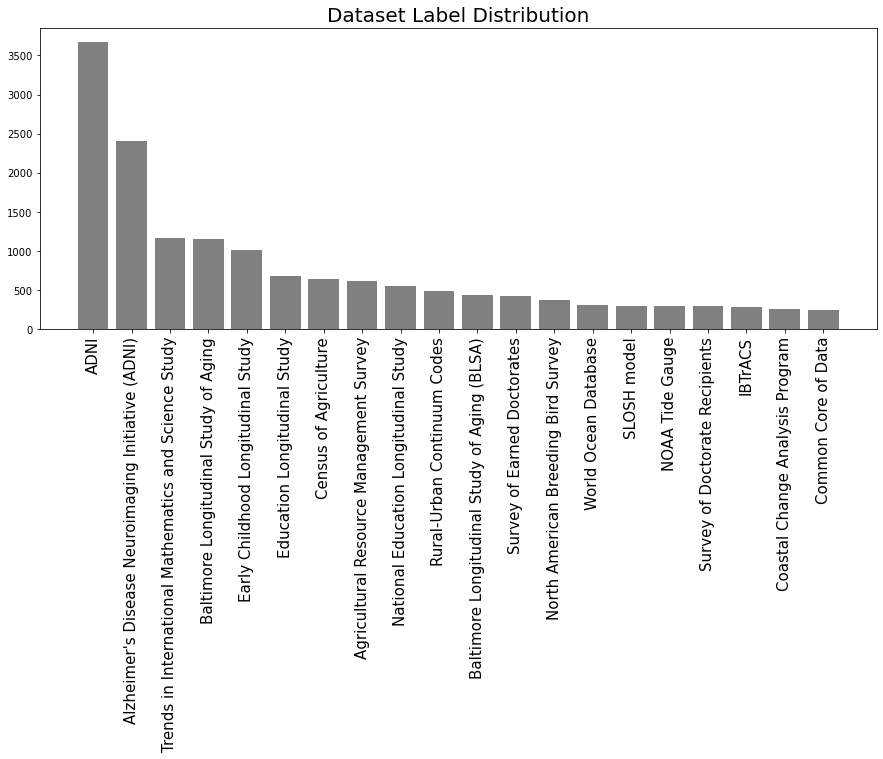

In [9]:
# Visualization of label
gs = fig.add_gridspec(5, 6)
dataset_label = train_df['dataset_label'].value_counts()[:20]
fig = plt.figure(figsize=(15, 7))

ax = fig.add_subplot(gs[1:,:])
dataset_label = train_df['dataset_label'].value_counts()[:20]
ax.bar(dataset_label.index, dataset_label,color='gray')
ax.set_xticks(range(len(dataset_label.index)))
ax.set_xticklabels(dataset_label.index, rotation = 90, fontsize = 15)


plt.title('Dataset Label Distribution', fontsize=20)
plt.show()

In [11]:
# word cloud

title = train_df.dataset_title.unique()
n = 1 # 라벨 몇개까지 할껀지
for i in range(n):
#     print(i,"th")
    ind = np.where(train_df.dataset_label == title[i])
    if i!=2 :
        txt = ''
        ind = np.array(ind)
        id = train_df.Id[ind[0,0]]
        json = pd.read_json(dataset_path/'train'/(id+'.json'))
        for j in range(len(json['text'])):
            txt += json['text'][j]
#         print(txt)

## 2. Modeling - LDA

In [84]:
# Path to the JSON files
train_files = glob.glob("../input/coleridgeinitiative-show-us-the-data/train/*.json")
test_files = glob.glob("../input/coleridgeinitiative-show-us-the-data/test/*.json")

# load json file using pandas
df_train = pd.DataFrame()
for count,ele in enumerate(train_files,len(train_files)):
    df_train = pd.concat([df_train, pd.read_json(ele)])

df_train.to_csv("df_train.csv",index=False)

df_test = pd.DataFrame()
num = []
for count,ele in enumerate(test_files,len(test_files)):
    df_test = pd.concat([df_test, pd.read_json(ele)])
    num.append(len(df_test))
# convert dataframe to csv file
df_test.to_csv("df_test.csv",index=False)

In [131]:
df_train

,section_title,text
0,Foreword,The International Standard Classification of E...
1,Introduction',A Guide to the International Interpretation of...
2,The Importance of International Data Comparabi...,Several persuasive arguments can be made for i...
3,Feasibility of Crosswalking U.S. Data to ISCED,The U.S. educational system differs in detail ...
4,Historical Efforts at International Data Cross...,"In 1978, the National Center for Education Sta..."
...,...,...
34,"Future plans, related initiatives, and conclus...","ADNI-2 is now about to enter its final year, a..."
35,Acknowledgments,
36,Supplementary data,Supplementary data related to this article can...
37,RESEARCH IN CONTEXT,1. Systematic review: Here we provide an updat...


In [86]:
num

[17, 30, 92, 118]

In [33]:
df = pd.read_csv('./df_train.csv').sample(1000)
docs_orig = array(df['text'])

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
docs_orig

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['Data used in this study are from the 1992, 1998, and 2004 USDA Agricultural Resource Management Survey (ARMS) of the hog sector. Because of broad differences in production techniques among various types of hog operations, we limit the sample to feeder pig-to-finish hog operations. 2 Over the period of this study, hog operations have become more specialized, with production shifting from farrow-to-finish operations to separate farrowing, nursery, and finishing operations. This study does not capture efficiency gains resulting from this specialization, but instead captures gains in efficiency within the feeder-to-finish product cycle. The analysis focuses on two major hog producing regions: the "Heartland" (IA, IL, IN, KY, MO, OH) and the "Southeast" (AL, AR, GA, NC, SC, VA). Producers located in the remaining surveyed states (CO, KS, MI, MN, NE, OK, PA, SD, TN, TX, UT, WI) were placed in the "Other regions" category. Table 1 lists the distribution of observations, farms, and out

In [36]:
def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = str(docs[idx]).lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
docs = docs_preprocessor(docs_orig)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
# Add bigrams and trigrams to docs (only ones that appear 10 times or more).
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
print('Number of unique words in initital documents:', len(dictionary))

# Filter out words that occur less than 10 documents, or more than 20% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.2)
print('Number of unique words after removing rare and common words:', len(dictionary))

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of unique words in initital documents: 18355
Number of unique words after removing rare and common words: 2619


In [40]:
corpus = [dictionary.doc2bow(doc) for doc in docs]

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
print(corpus[0])
print(dictionary[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 3), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 7), (22, 2), (23, 1), (24, 2), (25, 1), (26, 5), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 3), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 2), (39, 1), (40, 3), (41, 1), (42, 2), (43, 3), (44, 1), (45, 2), (46, 1), (47, 1), (48, 2), (49, 4), (50, 1), (51, 1), (52, 1), (53, 2), (54, 1), (55, 3), (56, 1), (57, 1), (58, 1), (59, 3), (60, 1), (61, 1), (62, 1), (63, 2), (64, 2), (65, 2), (66, 1), (67, 1), (68, 1), (69, 1), (70, 3), (71, 15), (72, 6), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 2), (79, 4), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 4), (86, 3), (87, 1), (88, 3), (89, 1), (90, 6), (91, 1), (92, 1), (93, 1), (94, 1), (95, 2), (96, 14), (97, 1), (98, 1), (99, 1), (100, 1), (101, 2), (102, 1), (103, 1), (104, 2), (105, 3), (106, 2), (107, 1), (108, 2), (109, 1), (110, 1

In [41]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 2619
Number of documents: 1000


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
print(len(dictionary))

2619


In [42]:
# Set training parameters.
num_topics = 10
chunksize = 500 # size of the doc looked at every pass
passes = 20 # number of passes through documents
iterations = 100
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

%time model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 40.6 s, sys: 15.2 ms, total: 40.6 s
Wall time: 40.6 s


In [151]:
topics = model.print_topics(num_words=4)
n = 0
topic_kw = []
for topic in topics:
    print(topic)
    wp = model.show_topic(n,topn=4)
    topic_keywords = " ".join([word for word, prop in wp])
    topic_kw.append(topic_keywords)
    print(topic_keywords)
    print()
    n+=1

(0, '0.017*"temperature" + 0.016*"normal" + 0.015*"during" + 0.013*"water"')
temperature normal during water

(1, '0.029*"school" + 0.025*"student" + 0.017*"test" + 0.014*"high_school"')
school student test high_school

(2, '0.019*"county" + 0.011*"farm" + 0.011*"climate_change" + 0.011*"change"')
county farm climate_change change

(3, '0.020*"response_rate" + 0.020*"farm" + 0.017*"response" + 0.016*"rate"')
response_rate farm response rate

(4, '0.058*"child" + 0.023*"health" + 0.022*"mental_health" + 0.022*"language"')
child health mental_health language

(5, '0.018*"associated_with" + 0.011*"patient" + 0.009*"disease" + 0.009*"brain"')
associated_with patient disease brain

(6, '0.019*"survey" + 0.013*"program" + 0.012*"information" + 0.011*"institution"')
survey program information institution

(7, '0.021*"student" + 0.012*"school" + 0.011*"science" + 0.011*"teacher"')
student school science teacher

(8, '0.013*"united_state" + 0.010*"woman" + 0.010*"country" + 0.010*"long_term"')


'temperature normal during water storm_surge average storm water_level region precipitation'

In [59]:
print(model.print_topics())

[(0, '0.017*"temperature" + 0.016*"normal" + 0.015*"during" + 0.013*"water" + 0.013*"storm_surge" + 0.012*"average" + 0.011*"storm" + 0.011*"water_level" + 0.011*"region" + 0.011*"precipitation"'), (1, '0.029*"school" + 0.025*"student" + 0.017*"test" + 0.014*"high_school" + 0.013*"score" + 0.012*"variable" + 0.011*"test_score" + 0.010*"standard_deviation" + 0.009*"difference" + 0.008*"grade"'), (2, '0.019*"county" + 0.011*"farm" + 0.011*"climate_change" + 0.011*"change" + 0.010*"land" + 0.008*"production" + 0.008*"agricultural" + 0.007*"rural" + 0.007*"crop" + 0.007*"state"'), (3, '0.020*"response_rate" + 0.020*"farm" + 0.017*"response" + 0.016*"rate" + 0.016*"sars" + 0.012*"farmer" + 0.010*"group" + 0.010*"more_likely" + 0.009*"control_group" + 0.008*"practice"'), (4, '0.058*"child" + 0.023*"health" + 0.022*"mental_health" + 0.022*"language" + 0.018*"early" + 0.016*"care" + 0.015*"literacy" + 0.013*"family" + 0.012*"early_childhood" + 0.012*"woman"'), (5, '0.018*"associated_with" + 0.

In [43]:
pyLDAvis.enable_notebook()
warnings.filterwarnings("ignore", category=DeprecationWarning) 

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
pyLDAvis.gensim.prepare(model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.080965 -0.042660       1        1  18.777408
5      0.025324  0.005433       2        1  15.400666
9     -0.037660 -0.154507       3        1  14.171783
1      0.064805 -0.078208       4        1  11.305674
8     -0.061598  0.010943       5        1   8.557412
0     -0.277175  0.191069       6        1   8.062174
2     -0.062162 -0.024031       7        1   7.320743
6      0.072308 -0.105512       8        1   7.313138
3     -0.050819 -0.046335       9        1   5.127609
4      0.246014  0.243808      10        1   3.963392, topic_info=                 Term         Freq        Total Category  logprob  loglift
1097            child   460.000000   460.000000  Default  30.0000  30.0000
645            school   957.000000   957.000000  Default  29.0000  29.0000
649           student  1218.000000  1218.000000  Default  28.0000  28.0000
71               farm   313.000000   313.000000  Default  27.0000  27.0000
1710           county   234.000000   234.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
32    consistent_with    43.074090   225.737865  Topic10  -5.0523   1.5716
811       development    44.716790   273.556786  Topic10  -5.0148   1.4169
157            sample    49.722166   444.655836  Topic10  -4.9087   1.0372
408         cognitive    43.127879   249.361575  Topic10  -5.0510   1.4733
231   associated_with    39.607663   849.765430  Topic10  -5.1361   0.1621

[608 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
1997      5  0.960336             1970s
1000      2  0.055289             1980s
1000      4  0.055289             1980s
1000      5  0.718755             1980s
1000      8  0.055289             1980s
...     ...       ...               ...
999       9  0.124193             would
1085      4  0.848136  year_institution
1085      8  0.117797  year_institution
2315      1  0.020819       young_child
2315     10  0.957688       young_child

[1908 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 6, 10, 2, 9, 1, 3, 7, 4, 5])

In [70]:
for i, topic_list in enumerate(model[corpus]):
    print(i, "번째 문서의 topic 비율은", topic_list)    

0 번째 문서의 topic 비율은 [(1, 0.0952909), (2, 0.47193062), (3, 0.27863747), (9, 0.15323527)]
1 번째 문서의 topic 비율은 [(0, 0.73211604), (9, 0.25910506)]
2 번째 문서의 topic 비율은 [(0, 0.1276045), (2, 0.39247307), (3, 0.46586892)]
3 번째 문서의 topic 비율은 [(0, 0.4551749), (8, 0.34723765), (9, 0.18889178)]
4 번째 문서의 topic 비율은 [(2, 0.4822499), (3, 0.033397734), (4, 0.09950299), (6, 0.15200739), (9, 0.23164208)]
5 번째 문서의 topic 비율은 [(1, 0.10829689), (3, 0.12246773), (4, 0.029945418), (5, 0.5688792), (7, 0.16405018)]
6 번째 문서의 topic 비율은 [(1, 0.06354439), (7, 0.5796188), (9, 0.3510377)]
7 번째 문서의 topic 비율은 [(0, 0.03492431), (2, 0.40289918), (6, 0.2936324), (7, 0.23434868), (8, 0.033492558)]
8 번째 문서의 topic 비율은 [(2, 0.5119447), (6, 0.4800501)]
9 번째 문서의 topic 비율은 [(2, 0.038571995), (4, 0.19401081), (7, 0.7556449)]
10 번째 문서의 topic 비율은 [(1, 0.30824202), (6, 0.36795226), (7, 0.07691454), (8, 0.24297085)]
11 번째 문서의 topic 비율은 [(0, 0.34154814), (8, 0.36640397), (9, 0.29109687)]
12 번째 문서의 topic 비율은 [(9, 0.99767154)]
13 번째 문서의 top

126 번째 문서의 topic 비율은 [(0, 0.27911964), (8, 0.5497203), (9, 0.16986945)]
127 번째 문서의 topic 비율은 [(5, 0.7821086), (9, 0.21272597)]
128 번째 문서의 topic 비율은 [(5, 0.36642247), (8, 0.52042484), (9, 0.10977517)]
129 번째 문서의 topic 비율은 [(5, 0.48860458), (6, 0.1301239), (9, 0.37847427)]
130 번째 문서의 topic 비율은 [(2, 0.16241512), (3, 0.5357053), (6, 0.22033238), (9, 0.07945792)]
131 번째 문서의 topic 비율은 [(0, 0.4272395), (2, 0.060061783), (8, 0.44939554), (9, 0.05457415)]
132 번째 문서의 topic 비율은 [(6, 0.7016278), (7, 0.15183625), (8, 0.090194084), (9, 0.053657085)]
133 번째 문서의 topic 비율은 [(1, 0.011337976), (5, 0.015246277), (6, 0.66436404), (7, 0.24976857), (8, 0.0100628985), (9, 0.019750534)]
134 번째 문서의 topic 비율은 [(2, 0.28591126), (5, 0.034579244), (7, 0.67766076)]
135 번째 문서의 topic 비율은 [(1, 0.5398357), (7, 0.076579206), (9, 0.37915692)]
136 번째 문서의 topic 비율은 [(7, 0.9402703), (9, 0.05667473)]
137 번째 문서의 topic 비율은 [(7, 0.93489754), (8, 0.054085337)]
138 번째 문서의 topic 비율은 [(3, 0.9428402), (6, 0.055205524)]
139 번째 문서의 top

262 번째 문서의 topic 비율은 [(3, 0.057625737), (6, 0.19072762), (9, 0.73958653)]
263 번째 문서의 topic 비율은 [(0, 0.049546514), (1, 0.6785463), (2, 0.19747895), (6, 0.07184309)]
264 번째 문서의 topic 비율은 [(2, 0.16593969), (5, 0.17513165), (6, 0.1089099), (9, 0.54652405)]
265 번째 문서의 topic 비율은 [(1, 0.62590325), (4, 0.37324655)]
266 번째 문서의 topic 비율은 [(1, 0.38793784), (4, 0.097306795), (7, 0.5133096)]
267 번째 문서의 topic 비율은 [(1, 0.15554574), (5, 0.52019334), (9, 0.3226965)]
268 번째 문서의 topic 비율은 [(0, 0.013489011), (3, 0.56693494), (4, 0.06047239), (7, 0.35639733)]
269 번째 문서의 topic 비율은 [(2, 0.28610998), (5, 0.05984633), (7, 0.53653336), (9, 0.11671262)]
270 번째 문서의 topic 비율은 [(5, 0.9117108), (6, 0.084759265)]
271 번째 문서의 topic 비율은 [(6, 0.9939321)]
272 번째 문서의 topic 비율은 [(1, 0.06307154), (6, 0.44973344), (7, 0.21781349), (8, 0.26624033)]
273 번째 문서의 topic 비율은 [(6, 0.43662003), (7, 0.3664656), (8, 0.19564573)]
274 번째 문서의 topic 비율은 [(2, 0.13108814), (6, 0.5542386), (9, 0.3116566)]
275 번째 문서의 topic 비율은 [(1, 0.14214282),

392 번째 문서의 topic 비율은 [(0, 0.079475224), (7, 0.17551623), (9, 0.7424693)]
393 번째 문서의 topic 비율은 [(1, 0.31698996), (5, 0.21362714), (6, 0.026489472), (9, 0.44144207)]
394 번째 문서의 topic 비율은 [(4, 0.074964106), (5, 0.7083601), (9, 0.21418819)]
395 번째 문서의 topic 비율은 [(4, 0.023486074), (5, 0.76415044), (6, 0.13099426), (8, 0.049050696), (9, 0.031635724)]
396 번째 문서의 topic 비율은 [(0, 0.0685402), (1, 0.100715145), (2, 0.08004722), (3, 0.061829686), (4, 0.05136221), (5, 0.13543263), (6, 0.10428453), (7, 0.13305333), (8, 0.08938877), (9, 0.17534631)]
397 번째 문서의 topic 비율은 [(0, 0.026598103), (1, 0.039084096), (2, 0.031063585), (3, 0.023993984), (4, 0.019931914), (5, 0.052557677), (6, 0.652343), (7, 0.05163344), (8, 0.03468872), (9, 0.068105556)]
398 번째 문서의 topic 비율은 [(0, 0.13819334), (2, 0.32680812), (8, 0.41854575), (9, 0.11572691)]
399 번째 문서의 topic 비율은 [(1, 0.56859183), (3, 0.05113138), (4, 0.16254586), (9, 0.21485372)]
400 번째 문서의 topic 비율은 [(3, 0.33619574), (5, 0.6422572)]
401 번째 문서의 topic 비율은 [(6, 0.

535 번째 문서의 topic 비율은 [(4, 0.54328793), (7, 0.4540123)]
536 번째 문서의 topic 비율은 [(0, 0.05270029), (3, 0.19912656), (4, 0.10219177), (5, 0.56048256), (9, 0.08351936)]
537 번째 문서의 topic 비율은 [(2, 0.076366395), (3, 0.09637805), (5, 0.2457631), (6, 0.29024848), (8, 0.1779117), (9, 0.11212374)]
538 번째 문서의 topic 비율은 [(3, 0.09819973), (5, 0.44215557), (8, 0.45618078)]
539 번째 문서의 topic 비율은 [(1, 0.013589356), (2, 0.4378987), (3, 0.018318132), (6, 0.43676955), (8, 0.092614405)]
540 번째 문서의 topic 비율은 [(6, 0.039710764), (7, 0.9531364)]
541 번째 문서의 topic 비율은 [(7, 0.93735737), (9, 0.058849193)]
542 번째 문서의 topic 비율은 [(1, 0.60368544), (5, 0.09194125), (6, 0.14851853), (9, 0.15429299)]
543 번째 문서의 topic 비율은 [(0, 0.44303045), (8, 0.3983675), (9, 0.15647274)]
544 번째 문서의 topic 비율은 [(1, 0.08334861), (4, 0.092838906), (6, 0.51690644), (9, 0.30525738)]
545 번째 문서의 topic 비율은 [(0, 0.0685402), (1, 0.100715145), (2, 0.08004722), (3, 0.061829686), (4, 0.05136221), (5, 0.13543263), (6, 0.10428453), (7, 0.13305333), (8, 0.08

686 번째 문서의 topic 비율은 [(2, 0.41862854), (3, 0.20056415), (8, 0.26962182), (9, 0.10901795)]
687 번째 문서의 topic 비율은 [(3, 0.13221613), (5, 0.65788174), (9, 0.20574148)]
688 번째 문서의 topic 비율은 [(1, 0.6120032), (4, 0.063329846), (6, 0.15358537), (7, 0.17003354)]
689 번째 문서의 topic 비율은 [(2, 0.04888494), (6, 0.12754738), (7, 0.82141984)]
690 번째 문서의 topic 비율은 [(1, 0.2178762), (7, 0.011487259), (9, 0.7688486)]
691 번째 문서의 topic 비율은 [(5, 0.10781072), (6, 0.021607738), (7, 0.09878982), (9, 0.77095497)]
692 번째 문서의 topic 비율은 [(5, 0.28906998), (7, 0.6957824)]
693 번째 문서의 topic 비율은 [(2, 0.6674397), (3, 0.047369387), (5, 0.05092834), (6, 0.22878613)]
694 번째 문서의 topic 비율은 [(5, 0.08315284), (6, 0.2951789), (9, 0.6181558)]
695 번째 문서의 topic 비율은 [(1, 0.29603162), (2, 0.22347157), (4, 0.47684744)]
696 번째 문서의 topic 비율은 [(4, 0.13534641), (6, 0.30558196), (7, 0.55786383)]
697 번째 문서의 topic 비율은 [(0, 0.041228708), (1, 0.08571506), (4, 0.36353868), (5, 0.074612245), (7, 0.43389428)]
698 번째 문서의 topic 비율은 [(1, 0.4023456), (6

795 번째 문서의 topic 비율은 [(7, 0.9930074)]
796 번째 문서의 topic 비율은 [(0, 0.14867309), (5, 0.25249022), (7, 0.10608335), (8, 0.40746915), (9, 0.08160391)]
797 번째 문서의 topic 비율은 [(5, 0.32729962), (9, 0.66484237)]
798 번째 문서의 topic 비율은 [(0, 0.019037925), (1, 0.06822479), (5, 0.48600364), (9, 0.4243374)]
799 번째 문서의 topic 비율은 [(4, 0.057746384), (5, 0.79253405), (7, 0.09299394), (8, 0.05514204)]
800 번째 문서의 topic 비율은 [(0, 0.08030703), (2, 0.3805983), (3, 0.1400537), (6, 0.025109863), (8, 0.37105954)]
801 번째 문서의 topic 비율은 [(1, 0.56052047), (7, 0.41975284)]
802 번째 문서의 topic 비율은 [(0, 0.29765525), (8, 0.6297137), (9, 0.068385996)]
803 번째 문서의 topic 비율은 [(0, 0.0685402), (1, 0.100715145), (2, 0.08004722), (3, 0.061829686), (4, 0.05136221), (5, 0.13543263), (6, 0.10428453), (7, 0.13305333), (8, 0.08938877), (9, 0.17534631)]
804 번째 문서의 topic 비율은 [(0, 0.5622952), (9, 0.43619972)]
805 번째 문서의 topic 비율은 [(0, 0.07973692), (2, 0.030753355), (9, 0.88502437)]
806 번째 문서의 topic 비율은 [(1, 0.8417273), (4, 0.14067838), (6, 0.

939 번째 문서의 topic 비율은 [(0, 0.4528143), (5, 0.09794881), (8, 0.2837268), (9, 0.16420206)]
940 번째 문서의 topic 비율은 [(0, 0.0685402), (1, 0.100715145), (2, 0.08004722), (3, 0.061829686), (4, 0.05136221), (5, 0.13543263), (6, 0.10428453), (7, 0.13305333), (8, 0.08938877), (9, 0.17534631)]
941 번째 문서의 topic 비율은 [(2, 0.21329702), (6, 0.44706118), (8, 0.32771683)]
942 번째 문서의 topic 비율은 [(5, 0.23953019), (6, 0.04448056), (9, 0.7097679)]
943 번째 문서의 topic 비율은 [(2, 0.3690035), (6, 0.25467354), (8, 0.19392368), (9, 0.17850044)]
944 번째 문서의 topic 비율은 [(0, 0.0685402), (1, 0.100715145), (2, 0.08004722), (3, 0.061829686), (4, 0.05136221), (5, 0.13543263), (6, 0.10428453), (7, 0.13305333), (8, 0.08938877), (9, 0.17534631)]
945 번째 문서의 topic 비율은 [(0, 0.04861052), (5, 0.2677436), (9, 0.68223304)]
946 번째 문서의 topic 비율은 [(5, 0.942347), (9, 0.05425471)]
947 번째 문서의 topic 비율은 [(2, 0.8620313), (4, 0.06699958), (9, 0.060655024)]
948 번째 문서의 topic 비율은 [(0, 0.38848594), (9, 0.6094257)]
949 번째 문서의 topic 비율은 [(0, 0.39966264),

In [66]:
# submission
df_test = pd.read_csv('./df_test.csv')
docs_test_orig = array(df_test['text'])
docs_test = docs_preprocessor(docs_test_orig)

In [67]:
# Add bigrams and trigrams to docs (only ones that appear 10 times or more).
bigram_test = Phrases(docs_test, min_count=10)
trigram_test = Phrases(bigram[docs_test])

for idx in range(len(docs_test)):
    for token in bigram_test[docs_test[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs_test[idx].append(token)
    for token in trigram_test[docs_test[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs_test[idx].append(token)

In [68]:
# Create a dictionary representation of the documents.
dictionary_test = Dictionary(docs_test)
print('Number of unique words in initital documents:', len(dictionary_test))

# Filter out words that occur less than 10 documents, or more than 20% of the documents.
dictionary_test.filter_extremes(no_below=10, no_above=0.2)
print('Number of unique words after removing rare and common words:', len(dictionary_test))

Number of unique words in initital documents: 3858
Number of unique words after removing rare and common words: 273


In [69]:
corpus_test = [dictionary_test.doc2bow(doc) for doc in docs_test]

In [71]:
for i, topic_list in enumerate(model[corpus_test]):
    print(i, "번째 문서의 topic 비율은", topic_list)    

0 번째 문서의 topic 비율은 [(0, 0.058057558), (2, 0.60112077), (3, 0.07169372), (9, 0.2660747)]
1 번째 문서의 topic 비율은 [(2, 0.87499017), (9, 0.10095728)]
2 번째 문서의 topic 비율은 [(1, 0.08115631), (2, 0.6320003), (3, 0.22650416), (9, 0.056705162)]
3 번째 문서의 topic 비율은 [(2, 0.7553299), (3, 0.07291451), (7, 0.05190968), (9, 0.11490869)]
4 번째 문서의 topic 비율은 [(1, 0.034973405), (2, 0.5485551), (3, 0.2087791), (4, 0.031195594), (9, 0.1736587)]
5 번째 문서의 topic 비율은 [(0, 0.02659665), (1, 0.03908196), (2, 0.64301735), (3, 0.023992673), (4, 0.019930825), (5, 0.052553892), (6, 0.040467046), (7, 0.05163062), (8, 0.034686822), (9, 0.06804218)]
6 번째 문서의 topic 비율은 [(1, 0.025857), (2, 0.635465), (3, 0.094110936), (9, 0.24317142)]
7 번째 문서의 topic 비율은 [(0, 0.0685402), (1, 0.100715145), (2, 0.08004722), (3, 0.061829686), (4, 0.05136221), (5, 0.13543263), (6, 0.10428453), (7, 0.13305333), (8, 0.08938877), (9, 0.17534631)]
8 번째 문서의 topic 비율은 [(0, 0.08742313), (2, 0.5612366), (3, 0.061289545), (7, 0.014137866), (9, 0.27372614)]
9 

In [90]:
def make_topic_per_doc(ldamodel, corpus):
    topic_table = pd.DataFrame()
    
    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list
        doc = sorted(doc, key = lambda x: (x[1]), reverse = True)  # 가중치 높은순으로 정렬
        
        for j, (topic_num, prop_topic) in enumerate(doc):
            if j==0:
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list]), ignore_index = True)
            else:
                break
    return(topic_table)        

In [108]:
topics = model.print_topics(num_words=4)
topics = np.array(topics)

In [127]:
topics[1,1]

'0.029*"school" + 0.025*"student" + 0.017*"test" + 0.014*"high_school"'

In [114]:
test_table = make_topic_per_doc(model, corpus_test)
test_table[:num[0]]

,0,1,2
0,2.0,0.6011,"[(0, 0.058069143), (2, 0.6011216), (3, 0.07168..."
1,2.0,0.8750,"[(2, 0.8749784), (9, 0.10096897)]"
2,2.0,0.6320,"[(1, 0.08115659), (2, 0.6320003), (3, 0.226504..."
3,2.0,0.7553,"[(2, 0.75533456), (3, 0.07291584), (7, 0.05189..."
4,2.0,0.5486,"[(1, 0.034976296), (2, 0.5485558), (3, 0.20877..."
5,2.0,0.6430,"[(0, 0.026596647), (1, 0.039081957), (2, 0.643..."
6,2.0,0.6355,"[(1, 0.025857763), (2, 0.63546485), (3, 0.0941..."
7,9.0,0.1753,"[(0, 0.0685402), (1, 0.100715145), (2, 0.08004..."
8,2.0,0.5612,"[(0, 0.08742295), (2, 0.56123525), (3, 0.06128..."
9,9.0,0.1753,"[(0, 0.0685402), (1, 0.100715145), (2, 0.08004..."


In [115]:
from collections import Counter 
def modefinder(numbers): # 최빈값
    c = Counter(numbers) 
    mode = c.most_common(1) 
    return mode[0][0]

In [118]:
top_topics_idx = []
for i in range(len(num)):
    max = modefinder(test_table[:num[i]][0])
    top_topics_idx.append(max)

In [153]:
top_topics = []
for i in range(len(num)):
    ind = int(top_topics_idx[i])
    top_topics.append(topic_kw[ind])

In [154]:
submission = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/sample_submission.csv')
submission['PredictionString'] = top_topics

In [155]:
submission

,Id,PredictionString
0,2100032a-7c33-4bff-97ef-690822c43466,county farm climate_change change
1,2f392438-e215-4169-bebf-21ac4ff253e1,county farm climate_change change
2,3f316b38-1a24-45a9-8d8c-4e05a42257c6,county farm climate_change change
3,8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,method image value feature


In [156]:
submission.to_csv('submission.csv', index = False)

In [157]:
'''
# reference
[1] Simple EDA and preprocessing of DataFrame, https://www.kaggle.com/tanlikesmath/simple-eda-and-preprocessing-of-dataframe
[2] [ShowUsTheData] EDA & Visualization Utils, https://www.kaggle.com/subinium/showusthedata-eda-visualization-utils
[3] [ShowUsTheData] Topic Modeling with LDA, https://www.kaggle.com/subinium/showusthedata-topic-modeling-with-lda

'''

'\n# reference\n[1] Simple EDA and preprocessing of DataFrame, https://www.kaggle.com/tanlikesmath/simple-eda-and-preprocessing-of-dataframe\n[2] [ShowUsTheData] EDA & Visualization Utils, https://www.kaggle.com/subinium/showusthedata-eda-visualization-utils\n[3] [ShowUsTheData] Topic Modeling with LDA, https://www.kaggle.com/subinium/showusthedata-topic-modeling-with-lda\n\n'